In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import altair as alt
from keras.engine.saving import load_model
import pickle
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
def predict_with_mode(model, X_holdout, mode):
    if mode == 'regular':
        pred = model.predict(X_holdout)
    if mode == 'lr':
        pred = model.predict(np.fliplr(X_holdout))
        pred = np.fliplr(pred)
    if mode == 'ud':
        pred = model.predict(X_holdout*(-1))
        pred = pred

    return pred


k=0
mode='ud'
input_file_name = f'/home/anton/Repos/gamma_log_classification/data/processed/{mode}_train_nn_0.pck'
#input_file_name = f'/home/anton/Repos/gamma_log_classification/data/interim/regular_train_nn_0.pck'

with open(input_file_name, 'rb') as f:
        results = pickle.load(f)

X, y = results[f'data_dict_train_{k}']['X_with_fake'], results[f'data_dict_train_{k}']['y_with_fake']
X = np.pad(X, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')
y = np.pad(y, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')

X_holdout, y_holdout = results[f'data_dict_test_{k}']['X'], results[f'data_dict_test_{k}']['y']
X_holdout = np.pad(X_holdout, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')
y_holdout = np.pad(y_holdout, pad_width=((0, 0), (2, 2), (0, 0)), mode='edge')

model = load_model(f'/home/anton/tmp_unets/fold0/unet-{mode}.hdf5')


Using TensorFlow backend.
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anton

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1104, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1104, 128)    512         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1104, 128)    0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1104, 128)    49280       dropout_1[0][0]                  
____________________________________________________________________________________________

In [30]:
pred = predict_with_mode(model,X_holdout,mode)


In [31]:
def prepare_df(pred,X,y):
    wells = np.arange(X.shape[0])
    list_df_wells = [pd.DataFrame({'GR':X[w,2:(X.shape[1] - 2)].flatten(),'row_id':np.arange(X.shape[1]-4),'well_id':w}) for w in wells]
    for df in list_df_wells:
        df.index = np.arange(df.shape[0])

    for i, df_well in enumerate(list_df_wells):
        df_well['pred'] = np.argmax(pred[i, :], axis=1)[2:(pred.shape[1] - 2)]
        df_well['label'] = np.argmax(y[i, :], axis=1)[2:(pred.shape[1] - 2)]
        for j in range(5):
            df_well[f'pred_proba_{j}'] = pred[i, 2:(pred.shape[1] - 2),j]
        
    result = pd.concat(list_df_wells, axis=0)
    return result

df_train= prepare_df(pred,X_holdout,y_holdout)

In [32]:
#df_train.to_csv('pred_regular_fold_0.csv',index=False)
scores =[]
wells_low_score = []
for w in np.arange(X_holdout.shape[0]):
    df_sub = df_train[df_train['well_id'] == w].copy()
    #df_sub.loc[df_sub['GR'] < (-0.9),'label'] = 2
    sc = accuracy_score(df_sub['label'],df_sub['pred'])
    scores.append(sc)
    if sc < 0.97:
        print(f'Accuracy {sc} for w = {w}')
        wells_low_score.append(w)
#print(np.mean(scores))


Accuracy 0.9554545454545454 for w = 15
Accuracy 0.9472727272727273 for w = 23
Accuracy 0.9345454545454546 for w = 30
Accuracy 0.9572727272727273 for w = 33
Accuracy 0.9681818181818181 for w = 36
Accuracy 0.96 for w = 39
Accuracy 0.9463636363636364 for w = 53
Accuracy 0.9663636363636363 for w = 66
Accuracy 0.9609090909090909 for w = 81
Accuracy 0.9527272727272728 for w = 84
Accuracy 0.9636363636363636 for w = 86
Accuracy 0.9545454545454546 for w = 87
Accuracy 0.9590909090909091 for w = 89
Accuracy 0.9681818181818181 for w = 91
Accuracy 0.9672727272727273 for w = 114
Accuracy 0.9663636363636363 for w = 126
Accuracy 0.9654545454545455 for w = 131
Accuracy 0.9345454545454546 for w = 141
Accuracy 0.9609090909090909 for w = 142
Accuracy 0.9672727272727273 for w = 150
Accuracy 0.9672727272727273 for w = 169
Accuracy 0.9545454545454546 for w = 176
Accuracy 0.9627272727272728 for w = 194
Accuracy 0.9572727272727273 for w = 226
Accuracy 0.9627272727272728 for w = 232
Accuracy 0.9645454545454546 

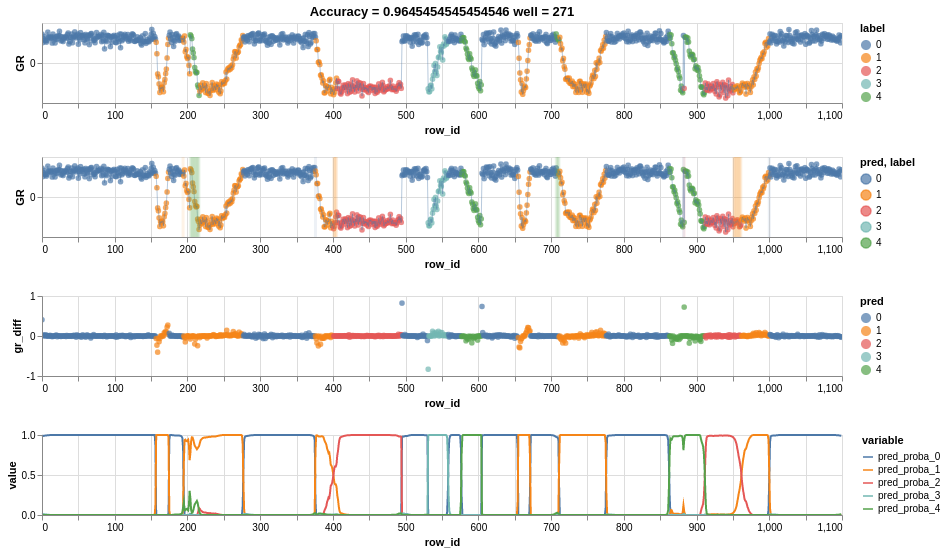

In [37]:
from sklearn.metrics import accuracy_score
from scipy.signal import medfilt
#well_ids = 80
#well_ids = 64
#well_ids = 80
well_ids  = np.random.choice(wells_low_score,1)[0]
#well_ids = 47
#well_ids = 647




df_sub = df_train[df_train['well_id'] == well_ids].copy()
#df_sub['gr_diff'] = medfilt(df_sub['GR'],3) - df_sub['GR']
df_sub['gr_diff'] = np.diff(medfilt(df_sub['GR'],11),prepend=0)

cols = ['GR','row_id','well_id','label','pred','gr_diff']
sc = accuracy_score(df_sub['label'],df_sub['pred'])
title= f'Accuracy = {sc} well = {well_ids}'
df_sub_rules = df_sub[df_sub['label'] !=  df_sub['pred']]

ch_rules = alt.Chart(df_sub_rules[['row_id','label']],height=80,width=800).encode(x='row_id',color='label:N').mark_rule(size=3,opacity=0.1)
ch_gr = alt.Chart(df_sub[cols],height=80,width=800,title=title).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
#ch_lab = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_grp = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR',order='row_id',color='pred:N').mark_point(size=30,filled=True)
ch_grp_l = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR',order='row_id').mark_line(size=0.4)
ch_grp_diff = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='gr_diff',order='row_id',color='pred:N').mark_point(size=30,filled=True)
df_probs = df_sub[[f'pred_proba_{j}' for j in range(5)]+['row_id']].melt(id_vars='row_id').reset_index()
ch_probs = alt.Chart(df_probs,height=80,width=800).encode(x='row_id',y='value',order='row_id',color='variable').mark_line()




ch_block = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y=alt.Y('GR',scale=alt.Scale(type='log')),order='row_id',color='label:N').mark_point(size=30,filled=True).interactive()

((ch_gr + ch_grp_l ).interactive() & (ch_grp+ch_grp_l+ch_rules).interactive() & ch_grp_diff.interactive() & ch_probs ).resolve_scale(color='independent',y='independent')


In [25]:
scores =[]
for w in np.arange(X_holdout.shape[0]):
    df_sub = df_train[df_train['well_id'] == w].copy()
    #df_sub.loc[df_sub['GR'] < (-0.9),'label'] = 2
    sc = accuracy_score(df_sub['label'],df_sub['pred'])
    scores.append(sc)
    if sc < 0.945:
        print(f'Accuracy {sc} for w = {w}')
print(np.mean(scores))

Accuracy 0.9345454545454546 for w = 30
Accuracy 0.9345454545454546 for w = 141
Accuracy 0.9336363636363636 for w = 294
Accuracy 0.9336363636363636 for w = 329
Accuracy 0.9445454545454546 for w = 376
Accuracy 0.9445454545454546 for w = 549
Accuracy 0.9427272727272727 for w = 564
Accuracy 0.9145454545454546 for w = 647
Accuracy 0.9445454545454546 for w = 717
Accuracy 0.9318181818181818 for w = 760
0.9823704545454547


# Check test submission

In [47]:
df_test = pd.read_csv('../data/processed/submit_nn_ud.csv')
df_test_GR = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')
df_test_regular = pd.read_csv('../data/processed/submit_nn_regular.csv')


/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


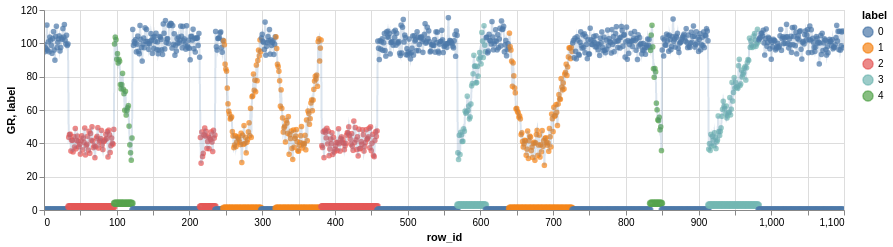

In [50]:
#=200
well_ids = df_test['well_id'].sample(10).values[5]
df_sub = df_test[df_test['well_id'] == well_ids]
df_sub['GR'] = df_test_GR[df_test_GR['well_id'] == well_ids]['GR']
#df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)

ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line


/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


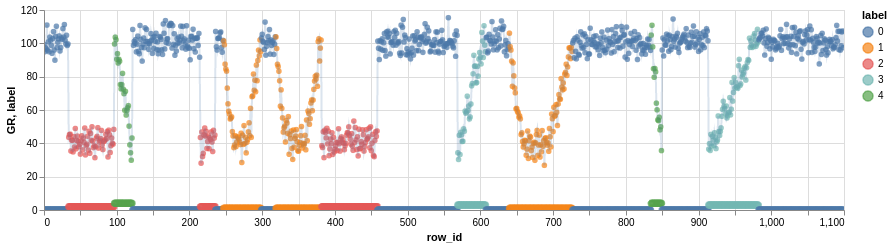

In [51]:
#=200
df_sub = df_test_regular[df_test_regular['well_id'] == well_ids]
df_sub['GR'] = df_test_GR[df_test_GR['well_id'] == well_ids]['GR']
#df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)

ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR:Q',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line


In [ ]:
import os
import pickle
with open(os.path.join('..', "data", "interim","test_dict"),'rb') as f:
    X_test,pred_test = pickle.load(f)
h=150
i=19
df_tmp = pd.DataFrame({'GR':X_test[i,:].flatten(),'label':np.argmax(pred_test[i,:], axis=1),'row_id':np.arange(X_test.shape[1])})
ch_gr = alt.Chart(df_tmp,height=h,width=700).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_tmp,height=h,width=700).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_line = alt.Chart(df_tmp,height=h,width=700).encode(x='row_id',y='GR',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line

In [ ]:
df_test


In [60]:
df_label_lags = calculate_lags(s=X['pred_proba_0'], note=f'pred_proba_0', lags=np.arange(-50, 50, 5))
df_label_lags

,pred_proba_0_lag_-50,pred_proba_0_lag_-45,pred_proba_0_lag_-40,pred_proba_0_lag_-35,pred_proba_0_lag_-30,pred_proba_0_lag_-25,pred_proba_0_lag_-20,pred_proba_0_lag_-15,pred_proba_0_lag_-10,pred_proba_0_lag_-5,pred_proba_0_lag_5,pred_proba_0_lag_10,pred_proba_0_lag_15,pred_proba_0_lag_20,pred_proba_0_lag_25,pred_proba_0_lag_30,pred_proba_0_lag_35,pred_proba_0_lag_40,pred_proba_0_lag_45
0,0.999999,0.999998,0.999997,0.999992,0.999960,0.999910,0.999923,0.999806,0.999199,0.993094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.999999,0.999999,0.999998,0.999994,0.999972,0.999909,0.999924,0.999864,0.999395,0.995528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.999999,0.999999,0.999998,0.999995,0.999979,0.999919,0.999923,0.999890,0.999631,0.997032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.999999,0.999999,0.999998,0.999996,0.999985,0.999933,0.999923,0.999915,0.999727,0.998255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.999999,0.999999,0.999998,0.999997,0.999990,0.999947,0.999915,0.999924,0.999785,0.998772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998702,0.999794,0.999945,0.999989,0.999994,0.999994,0.999986,0.999849,0.996901
1096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998341,0.999724,0.999929,0.999981,0.999993,0.999994,0.999988,0.999924,0.997677
1097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998102,0.999679,0.999922,0.999976,0.999993,0.999995,0.999990,0.999955,0.998772
1098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997739,0.999538,0.999904,0.999972,0.999994,0.999995,0.999992,0.999974,0.999365


In [52]:
(df_test['label'] == df_test_regular['label']).mean()

0.9945688311688312